In [ ]:
!pip install --quiet lightgbm xgboost catboost shap nbformat matplotlib seaborn scikit-learn pandas numpy joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
DATA_PATH = "/content/global_air_quality_data_10000.csv"
import pandas as pd
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
df.head()

Loaded: /content/global_air_quality_data_10000.csv shape: (10000, 12)


,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16


In [ ]:
import numpy as np

pm25_breakpoints = [
    (0.0, 12.0, 0, 50),
    (12.1, 35.4, 51, 100),
    (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200),
    (150.5, 250.4, 201, 300),
    (250.5, 350.4, 301, 400),
    (350.5, 500.4, 401, 500)
]
pm10_breakpoints = [
    (0, 54, 0, 50),
    (55, 154, 51, 100),
    (155, 254, 101, 150),
    (255, 354, 151, 200),
    (355, 424, 201, 300),
    (425, 504, 301, 400),
    (505, 604, 401, 500)
]

def _aqi_from_bp(C, bp_list):
    if pd.isna(C): return np.nan
    for (Clow, Chigh, Ilow, Ihigh) in bp_list:
        if C >= Clow and C <= Chigh:
            aqi = (Ihigh - Ilow)/(Chigh - Clow) * (C - Clow) + Ilow
            return round(aqi, 2)
    Clow, Chigh, Ilow, Ihigh = bp_list[-1]
    aqi = (Ihigh - Ilow)/(Chigh - Clow) * (C - Clow) + Ilow
    return round(aqi, 2)

def compute_aqi_row(row):
    pm25 = row.get('PM2.5', np.nan)
    pm10 = row.get('PM10', np.nan)
    aqi_pm25 = _aqi_from_bp(pm25, pm25_breakpoints)
    aqi_pm10 = _aqi_from_bp(pm10, pm10_breakpoints)
    return np.nanmax([aqi_pm25, aqi_pm10])

df['AQI'] = df.apply(compute_aqi_row, axis=1)
def aqi_category(aqi):
    if pd.isna(aqi): return np.nan
    aqi = float(aqi)
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Moderate"
    if aqi <= 150: return "Unhealthy for Sensitive"
    if aqi <= 200: return "Unhealthy"
    if aqi <= 300: return "Very Unhealthy"
    return "Hazardous"
df['AQI_cat'] = df['AQI'].map(aqi_category)
print(df['AQI'].describe())
print(df['AQI_cat'].value_counts())

count    10000.000000
mean       149.622143
std         40.574621
min         22.210000
25%        119.022500
50%        162.625000
75%        181.020000
max        206.160000
Name: AQI, dtype: float64
AQI_cat
Unhealthy                  6508
Unhealthy for Sensitive    1874
Moderate                   1493
Good                        119
Very Unhealthy                6
Name: count, dtype: int64


In [ ]:
vc = df['AQI_cat'].value_counts(normalize=True, dropna=True)
print('Category proportions:\n', vc)
if vc.max() > 0.6:
    print('Imbalanced detected; creating quantile bins (q=4).')
    df['AQI_cat_q'] = pd.qcut(df['AQI'].rank(method='first'), q=4, labels=['Low','Medium','High','VeryHigh'])
    target_col = 'AQI_cat_q'
else:
    target_col = 'AQI_cat'
print('Using target column:', target_col)
print(df[target_col].value_counts())

Category proportions:
 AQI_cat
Unhealthy                  0.6508
Unhealthy for Sensitive    0.1874
Moderate                   0.1493
Good                       0.0119
Very Unhealthy             0.0006
Name: proportion, dtype: float64
Imbalanced detected; creating quantile bins (q=4).
Using target column: AQI_cat_q
AQI_cat_q
Low         2500
Medium      2500
High        2500
VeryHigh    2500
Name: count, dtype: int64


In [ ]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['hour'] = df['Date'].dt.hour.fillna(-1).astype(int)
    df['dayofweek'] = df['Date'].dt.dayofweek.fillna(-1).astype(int)
    df['month'] = df['Date'].dt.month.fillna(-1).astype(int)

drop_cols = ['City','Date']  # City text may be high-cardinality; adjust if needed
drop_cols = [c for c in drop_cols if c in df.columns]
X = df.drop(columns=drop_cols + ['AQI','AQI_cat','AQI_cat_q'] if 'AQI_cat_q' in df.columns else drop_cols + ['AQI','AQI_cat'], errors='ignore')
print('Final feature columns:', X.columns.tolist())

Final feature columns: ['Country', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed', 'hour', 'dayofweek', 'month']


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# Prepare features and target
y = df[target_col].astype(str).reset_index(drop=True)
le = LabelEncoder()
y_enc = le.fit_transform(y)
X = X.reset_index(drop=True)
mask = ~pd.isna(y_enc)
X = X[mask].reset_index(drop=True)
y_enc = y_enc[mask]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print('Numeric cols:', numeric_cols)
print('Categorical cols:', cat_cols)

numeric_pipe = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer([('num', numeric_pipe, numeric_cols), ('cat', cat_pipe, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
print('Train/test shapes:', X_train.shape, X_test.shape)

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
}


missing = []
try:
    import lightgbm as lgb
    models['LightGBM'] = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=50, class_weight='balanced', random_state=42)
except Exception as e:
    missing.append('lightgbm')
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
except Exception as e:
    missing.append('xgboost')
try:
    from catboost import CatBoostClassifier
    models['CatBoost'] = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=False, random_state=42)
except Exception as e:
    pass

print('Models to run:', list(models.keys()))
if missing:
    print('Missing libs:', missing, '\nInstall them with pip if you want full comparison.')


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    try:
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_mean = cv_scores.mean()
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        results[name] = {'CV_Accuracy': cv_mean, 'Test_Accuracy': test_acc, 'Model': pipe}
        print(f"{name}: CV={cv_mean:.4f}, Test={test_acc:.4f}")
        print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))
    except Exception as e:
        print(f"{name} failed: {e}")

Numeric cols: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed', 'hour', 'dayofweek', 'month']
Categorical cols: ['Country']
Train/test shapes: (8000, 13) (2000, 13)
Models to run: ['LogisticRegression', 'LightGBM', 'XGBoost', 'CatBoost']
LogisticRegression: CV=0.9639, Test=0.9580
              precision    recall  f1-score   support

        High       0.97      0.99      0.98       500
         Low       0.94      0.93      0.94       500
      Medium       0.93      0.92      0.93       500
    VeryHigh       0.99      0.99      0.99       500

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: CV=0.9951, Test=0.9965
              precision    recall  f1-score   support

        High       0.99      1.00      1.00       500
         Low       0.99      1.00      1.00       500
      Medium       1.00      1.00      1.00       500
    VeryHigh       1.00      0.99      0.99       500

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:00:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: CV=0.9924, Test=0.9955
              precision    recall  f1-score   support

        High       0.99      0.99      0.99       500
         Low       1.00      1.00      1.00       500
      Medium       1.00      0.99      0.99       500
    VeryHigh       1.00      1.00      1.00       500

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

CatBoost: CV=0.9941, Test=0.9935
              precision    recall  f1-score   support

        High       0.99      0.99      0.99       500
         Low       1.00      1.00      1.00       500
      Medium       0.99      0.99      0.99       500
    VeryHigh       1.00      1.00      1.00       500

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                    CV_Accuracy  Test_Accuracy
LogisticRegression     0.963875         0.9580
LightGBM               0.995125         0.9965
XGBoost                0.992375         0.9955
CatBoost               0.994125         0.9935


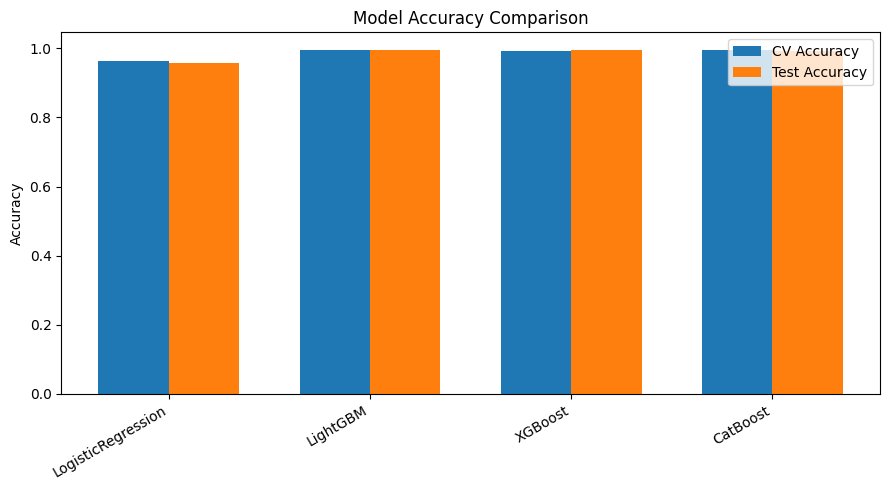

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame({k: {'CV_Accuracy': v['CV_Accuracy'], 'Test_Accuracy': v['Test_Accuracy']} for k,v in results.items()}).T
print(results_df)
fig, ax = plt.subplots(figsize=(9,5))
x = range(len(results_df))
width = 0.35
ax.bar([i - width/2 for i in x], results_df['CV_Accuracy'], width, label='CV Accuracy')
ax.bar([i + width/2 for i in x], results_df['Test_Accuracy'], width, label='Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=30, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.legend()
plt.tight_layout()
plt.show()

Best model for SHAP: LightGBM
SHAP values computed. Showing summary plot...


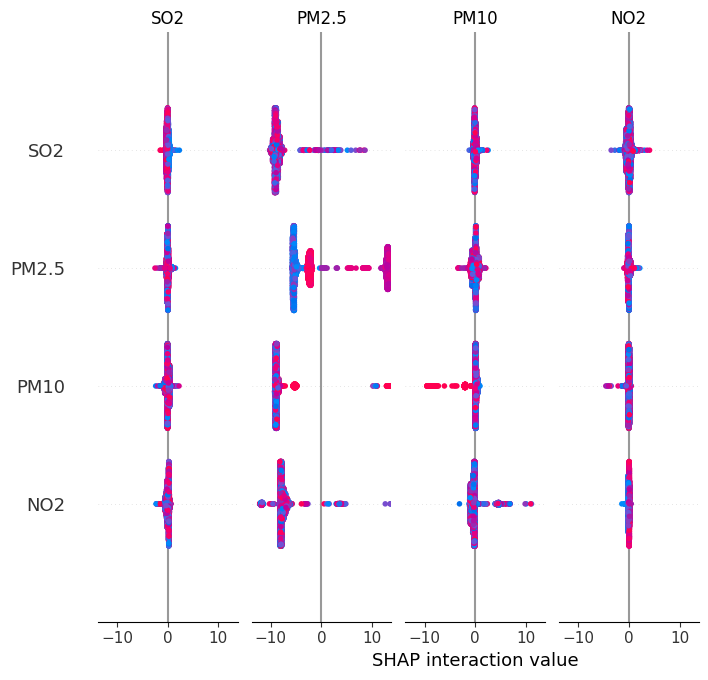

Example test index: 920
True label: High
Predicted label: High


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


SHAP error: index 920 is out of bounds for axis 0 with size 13
Install shap with: pip install shap


In [ ]:

try:
    import shap, numpy as np
    best_model_name = results_df['Test_Accuracy'].idxmax()
    best_pipe = results[best_model_name]['Model']
    print('Best model for SHAP:', best_model_name)
    clf = best_pipe.named_steps['clf']
    pre = best_pipe.named_steps['pre']
    X_train_trans = pre.transform(X_train)
    feature_names = numeric_cols + cat_cols
    if hasattr(clf, 'feature_importances_') or 'LGBM' in best_model_name or 'XGBoost' in best_model_name or 'RandomForest' in best_model_name or 'CatBoost' in best_model_name:
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_train_trans)
        print('SHAP values computed. Showing summary plot...')
        shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names)
        # Local force plot for a random test instance
        idx = np.random.randint(0, X_test.shape[0])
        X_sample = pre.transform(X_test.iloc[[idx]])
        print('Example test index:', idx)
        print('True label:', le.inverse_transform([y_test[idx]])[0])
        print('Predicted label:', le.inverse_transform(best_pipe.predict(X_test.iloc[[idx]]))[0])
        shap.initjs()
        display(shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], feature_names=feature_names))
    else:
        print('Best model not tree-based or SHAP TreeExplainer not suitable.')
except Exception as e:
    print('SHAP error:', e)
    print('Install shap with: pip install shap')

In [ ]:
import joblib
best_model_name = results_df['Test_Accuracy'].idxmax()
best_pipe = results[best_model_name]['Model']
joblib.dump({'model': best_pipe, 'label_encoder': le, 'feature_names': numeric_cols + cat_cols}, 'best_air_quality_model.pkl')
print('Saved best model to best_air_quality_model.pkl')

Saved best model to best_air_quality_model.pkl


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact
import joblib

# Load the trained model bundle
bundle = joblib.load("best_air_quality_model.pkl")
model = bundle["model"]
le = bundle["label_encoder"]

# --- AQI Category Mapper ---
def aqi_category(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Moderate"
    elif aqi <= 150: return "Unhealthy for Sensitive Groups"
    elif aqi <= 200: return "Unhealthy"
    elif aqi <= 300: return "Very Unhealthy"
    else: return "Hazardous"

# --- Prediction Function (interactive) ---
def predict_aqi_interactive(
    pm25, pm10, no2, so2, co, o3,
    temperature, humidity, wind_speed,
    country_code, hour, dayofweek, month
):
    # Assemble DataFrame matching training features
    data = pd.DataFrame([{
        "PM2.5": pm25,
        "PM10": pm10,
        "NO2": no2,
        "SO2": so2,
        "CO": co,
        "O3": o3,
        "Temperature": temperature,
        "Humidity": humidity,
        "Wind Speed": wind_speed,
        "Country": country_code,
        "hour": hour,
        "dayofweek": dayofweek,
        "month": month
    }])

    # Predict AQI category
    pred_encoded = model.predict(data)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]

    # Display results
    print(f"\n📊 Predicted AQI Category: **{pred_label}**")

    # Optional: Highlight key pollutants above typical healthy thresholds
    critical_factors = []
    if pm25 > 100: critical_factors.append("PM2.5")
    if pm10 > 150: critical_factors.append("PM10")
    if no2 > 80: critical_factors.append("NO₂")
    if so2 > 60: critical_factors.append("SO₂")
    if co > 9: critical_factors.append("CO")
    if o3 > 120: critical_factors.append("O₃")

    if critical_factors:
        print("⚠️ High-risk pollutants influencing AQI:", ", ".join(critical_factors))
    else:
        print("✅ All pollutant levels are within normal limits.")

# --- Interactive Sliders ---
interact(
    predict_aqi_interactive,
    pm25=widgets.FloatSlider(value=75, min=0, max=500, step=1, description="PM2.5 (µg/m³)"),
    pm10=widgets.FloatSlider(value=100, min=0, max=500, step=1, description="PM10 (µg/m³)"),
    no2=widgets.FloatSlider(value=40, min=0, max=200, step=1, description="NO₂ (ppb)"),
    so2=widgets.FloatSlider(value=20, min=0, max=100, step=1, description="SO₂ (ppb)"),
    co=widgets.FloatSlider(value=4, min=0, max=10, step=0.1, description="CO (ppm)"),
    o3=widgets.FloatSlider(value=90, min=0, max=200, step=1, description="O₃ (ppb)"),
    temperature=widgets.FloatSlider(value=30, min=-10, max=50, step=1, description="Temp (°C)"),
    humidity=widgets.FloatSlider(value=50, min=0, max=100, step=1, description="Humidity (%)"),
    wind_speed=widgets.FloatSlider(value=2, min=0, max=15, step=0.1, description="Wind (m/s)"),
    country_code=widgets.Text(value="India", description="Country"),
    hour=widgets.IntSlider(value=12, min=0, max=23, step=1, description="Hour"),
    dayofweek=widgets.IntSlider(value=3, min=0, max=6, step=1, description="Day of Week"),
    month=widgets.IntSlider(value=datetime.now().month, min=1, max=12, step=1, description="Month")
)


interactive(children=(FloatSlider(value=75.0, description='PM2.5 (µg/m³)', max=500.0, step=1.0), FloatSlider(v…

<function __main__.predict_aqi_interactive(pm25, pm10, no2, so2, co, o3, temperature, humidity, wind_speed, country_code, hour, dayofweek, month)>

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


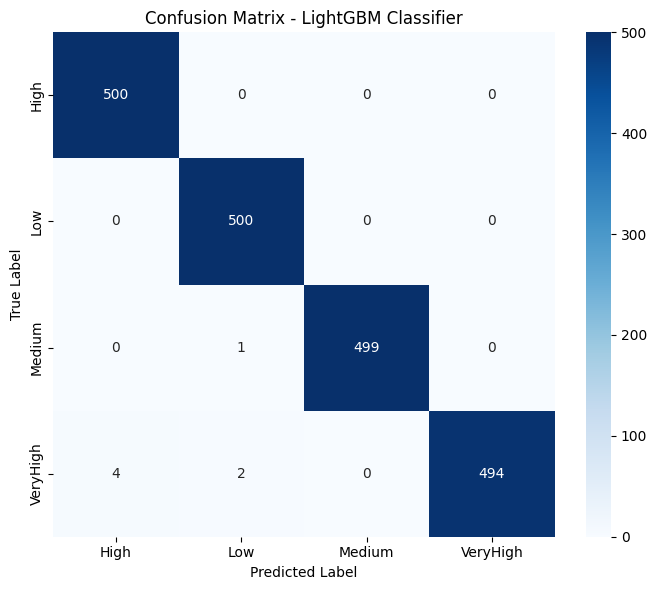

In [ ]:
# ==========================================
# CONFUSION MATRIX FOR LIGHTGBM CLASSIFIER
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Select trained LightGBM model from your results dictionary
lightgbm_model = results['LightGBM']['Model']

# Predict on test data
y_pred = lightgbm_model.predict(X_test)

# Decode labels to original AQI categories
y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Plot confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - LightGBM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
